# Sentiment Analysis Between Communities

## Preprocessing

In [141]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

#### Load data, split post properties into columns, create networkx graphs

In [125]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# separate post properties into different columns
post_colnames_df = pd.read_csv("post_properties_column_names.csv")
col_list = list(post_colnames_df['Colname'].values)
df_full[col_list] = df_full.loc[:,'PROPERTIES'].str.split(',', expand=True)
df_full[col_list] = df_full[col_list].astype(float) # correct datatype

## filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only connections where both are political
df = df_full[source_is_political & target_is_political]
df_psource = df_full[source_is_political]
df_ptarget = df_full[target_is_political]

# create graphs
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# add link sentiments
links = df.groupby([source, target])['LINK_SENTIMENT'].sum().reset_index()
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

#### Use Louvain Community Detection

In [3]:
# Compute the best partition
partition = community_louvain.best_partition(G_undirected, weight='count')

nx.set_node_attributes(G_undirected, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_83258/3642016997.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_83258/3642016997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)


# Sentiment Analysis
- Sentiment variables:
  - **'LINK_SENTIMENT'** : -1/1 classification of link sentiment
  - **'sentiment_positive'** : VADER positive sentiment of entire post
  - **'sentiment_negative'** : VADER negative sentiment of entire post
  - **'sentiment_compound'** : VADER sentiment of entire post, [-1,1]

## Distributions of post sentiment (VADER)
When looking at the distribution of post sentiments, it appears that political subreddits have a larger proportion of negative posts compared with the full dataset.  The distribution of all posts in the full dataset which hyperlink a political subreddit, it is clear that there is a larger proportion of negative posts linking political subreddits than negative posts in the full dataset or negative posts originating from political subreddits.  This could indicate a negative perception of political subreddits from other non-political communities.

### Post sentiments over whole dataset

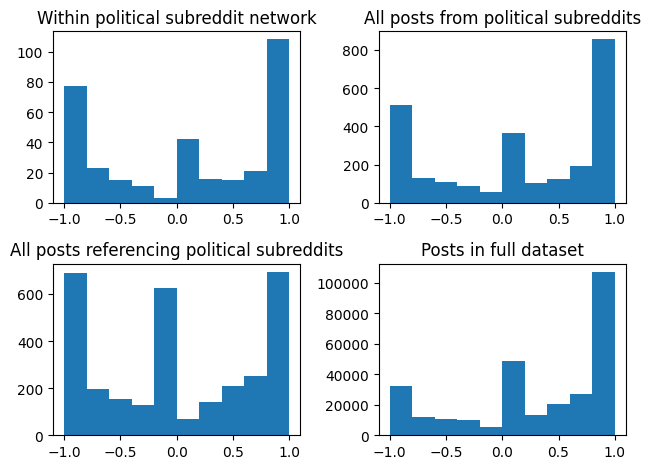

In [61]:
dfs = [df, df_psource, df_ptarget, df_full]

fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), dfs):
    ax.hist(data['sentiment_compound'])

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("All posts from political subreddits")
axs[1][0].set_title("All posts referencing political subreddits")
axs[1][1].set_title("Posts in full dataset")

plt.tight_layout()
plt.show()

### Post sentiments by louvain community
**When the political subreddits are the source post:**

Communities with more negative posts in dataset than positive: 
- Community 5 (ukpolitics)
- Community 7 (gunpolitics)
- Community 12 (europes)

Most neutral:
- Community 3 (worldpolitics)

All other communities have majority positive posts. 

----------------------------------------------


**When the political subreddits are the target post:**
- Many of the sentiment distributions shift to be more negative when political subreddits are the ones hyperlinked
- The exception to this are Community 5 and 12 (related to European politics) which show the opposite effect - the distribution shifts to be more positive.

NOTE: these are relatively small sample sizes when dividing by community.

			VADER SENTIMENT BY COMMUNITY, SOURCE VS TARGET 





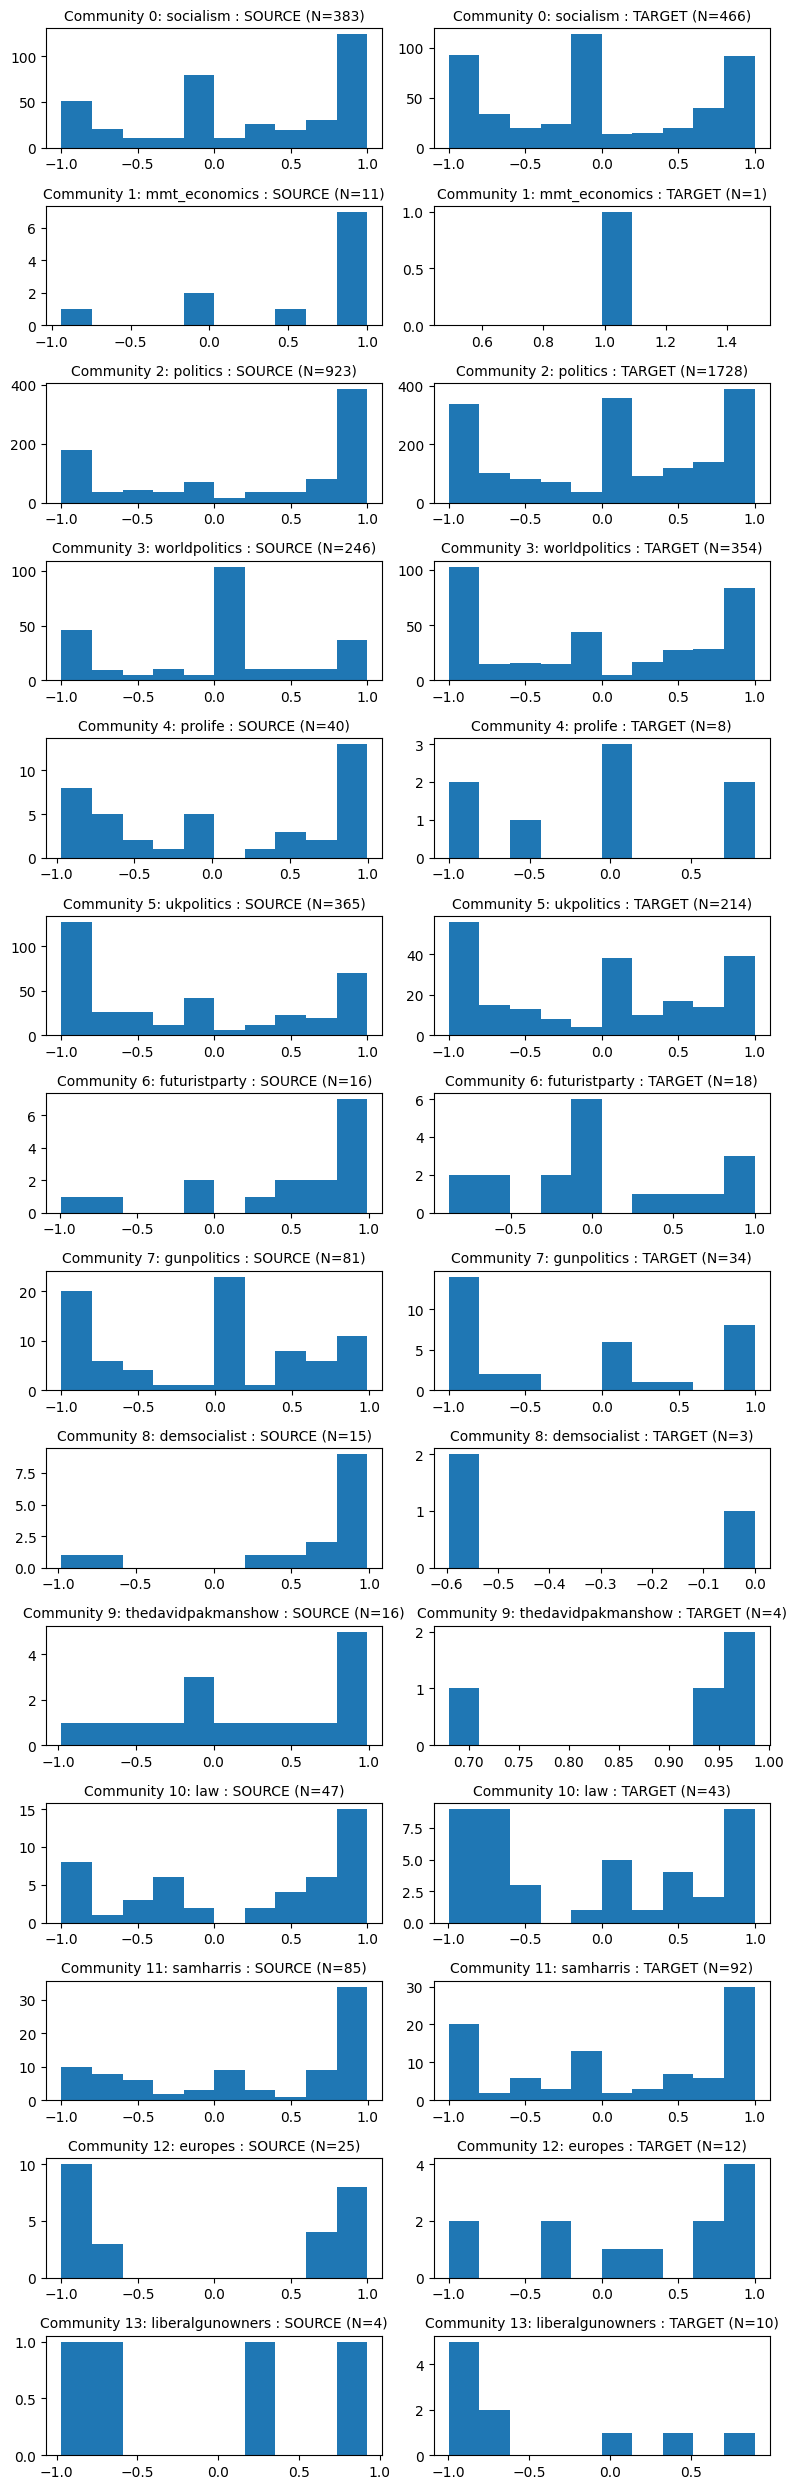

In [105]:
def plot_vader_distribution(df, sentiment):
    """
    sentiment must either be 'positive', 'negative', or 'compound'
    """
    fig, axs = plt.subplots(14,2, figsize=(8,25))
    flat_ax = axs.flatten()
    
    for i, comm in enumerate(communities):
        idx_source = df[source].isin(comm)
        idx_target = df[target].isin(comm)
        x_source = df[idx_source][f'sentiment_{sentiment}']
        x_target = df[idx_target][f'sentiment_{sentiment}']
        flat_ax[i*2].hist(x_source)
        flat_ax[i*2+1].hist(x_target)
        flat_ax[i*2].set_title(f'Community {i}: {community_labels[i][0]} : SOURCE (N={len(x_source)})', fontdict={'fontsize': 10})
        flat_ax[i*2+1].set_title(f'Community {i}: {community_labels[i][0]} : TARGET (N={len(x_target)})', fontdict={'fontsize': 10})
        ax.set_xlim([-1, 1])

    plt.tight_layout()
    plt.show()
    
print("\t\t\tVADER SENTIMENT BY COMMUNITY, SOURCE VS TARGET \n\n\n")

plot_vader_distribution(df_full, 'compound')

## Hyperlink sentiments

LINK_SENTIMENT
 1    289
-1     42
Name: count, dtype: int64 


LINK_SENTIMENT
 1    2202
-1     331
Name: count, dtype: int64 


LINK_SENTIMENT
 1    2673
-1     485
Name: count, dtype: int64 


LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64 




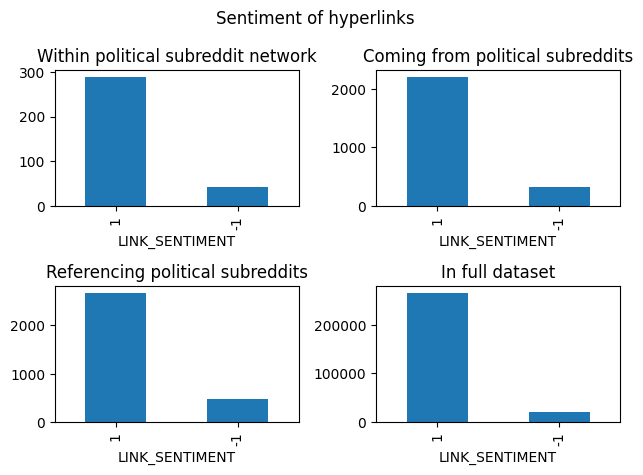

In [59]:
def sentiment_value_counts(df, ax):
    value_counts = df['LINK_SENTIMENT'].value_counts()
    print(value_counts, "\n\n")
    df['LINK_SENTIMENT'].value_counts().plot(kind='bar', ax=ax)
    
fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), [df, df_psource, df_ptarget, df_full]):
    sentiment_value_counts(data, ax)

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("Coming from political subreddits")
axs[1][0].set_title("Referencing political subreddits")
axs[1][1].set_title("In full dataset")
plt.suptitle("Sentiment of hyperlinks")
plt.tight_layout()
plt.show()

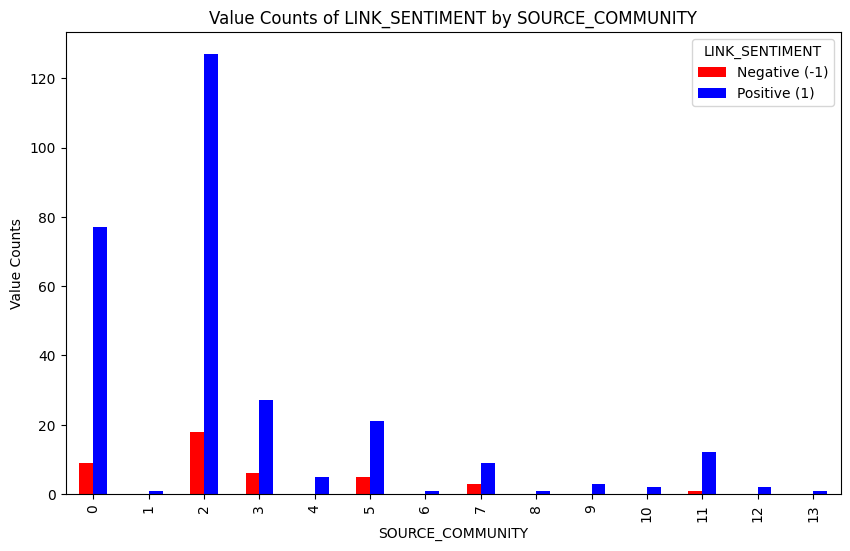

In [5]:
temp = df.groupby(by='SOURCE_COMMUNITY')['LINK_SENTIMENT'].value_counts()

temp = pd.Series(temp).unstack().fillna(0)  # Unstack to get LINK_SENTIMENT in columns
temp.index = temp.index.astype(int)  # Convert index to integers for sorting
temp = temp.sort_index()  # Sort by SOURCE_COMMUNITY for a cleaner plot
temp.plot(kind='bar', stacked=False, color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('SOURCE_COMMUNITY')
plt.ylabel('Value Counts')
plt.title('Value Counts of LINK_SENTIMENT by SOURCE_COMMUNITY')
plt.legend(title='LINK_SENTIMENT', labels=['Negative (-1)', 'Positive (1)'])
plt.show()

## Networks by sentiment

### Political network graph

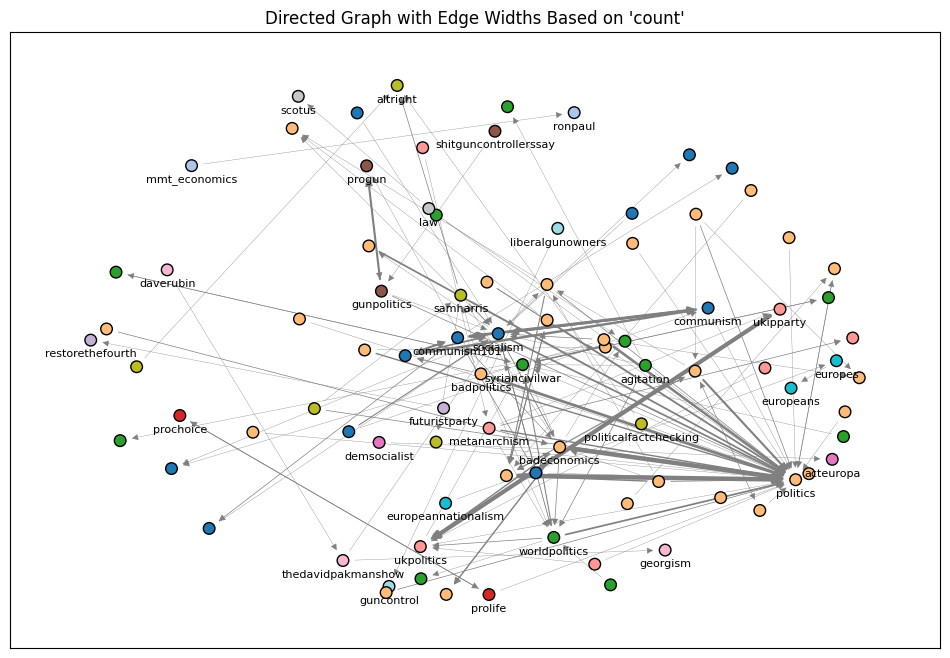

In [146]:
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_directed.nodes()]

pos = nx.spring_layout(G_directed, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_directed, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_directed, label_pos, 
                        labels={node: node for node in sum(community_labels.values(),[])},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_directed.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_directed, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph with Edge Widths Based on 'count'")
plt.show()

### Network of Negative Hyperlinks in Political Graph

In [152]:
# create graph from political network with negative edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_negative_edges = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

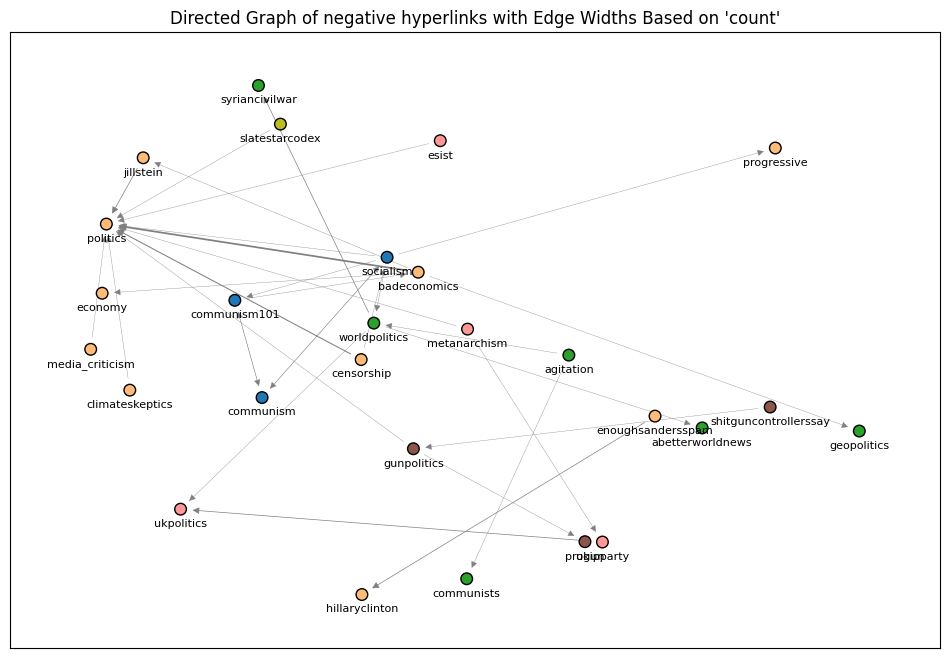

In [174]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_negative_edges.nodes()]

pos = nx.spring_layout(G_negative_edges, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_negative_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_negative_edges, label_pos, 
                        labels={node: node for node in G_negative_edges.nodes},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_negative_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_negative_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph of negative hyperlinks with Edge Widths Based on 'count'")
plt.show()

### Network of positive hyperlinks in political network graph

In [175]:
# create graph from political network with positive edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_positive_edges = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

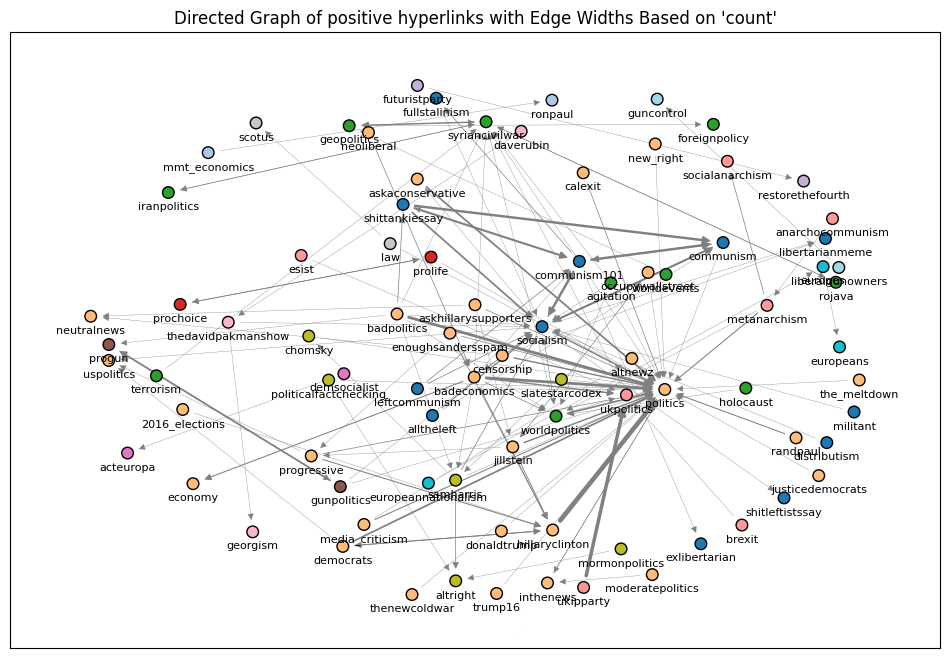

In [176]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_positive_edges.nodes()]

pos = nx.spring_layout(G_positive_edges, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_positive_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_positive_edges, label_pos, 
                        labels={node: node for node in G_positive_edges.nodes},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_positive_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_positive_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph of positive hyperlinks with Edge Widths Based on 'count'")
plt.show()

### Network with all negative hyperlinks targeting political subs

In [177]:
# create graph from subreddits negatively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_nt = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

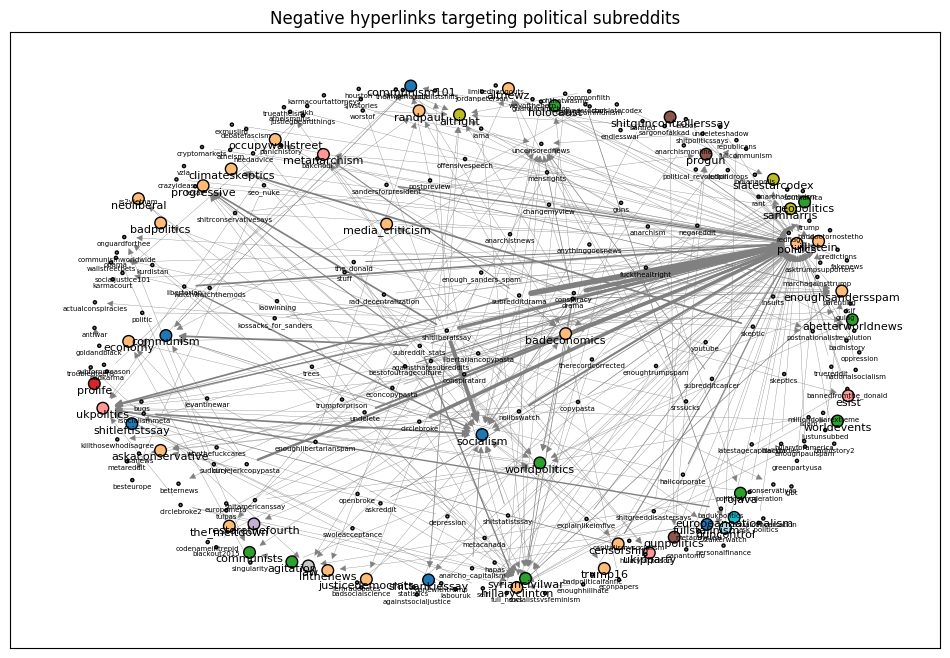

In [208]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_nt.nodes()]

node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

pos = nx.spring_layout(G_nt, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_nt, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")
# Define the positions and labels
labels = {node: node for node in G_nt.nodes()}

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    # Set font size based on node size
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")
##

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_nt.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_nt, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Negative hyperlinks targeting political subreddits")
plt.show()

### Network with all positive hyperlinks targeting political subs

In [210]:
# create graph from subreddits positively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_pt = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

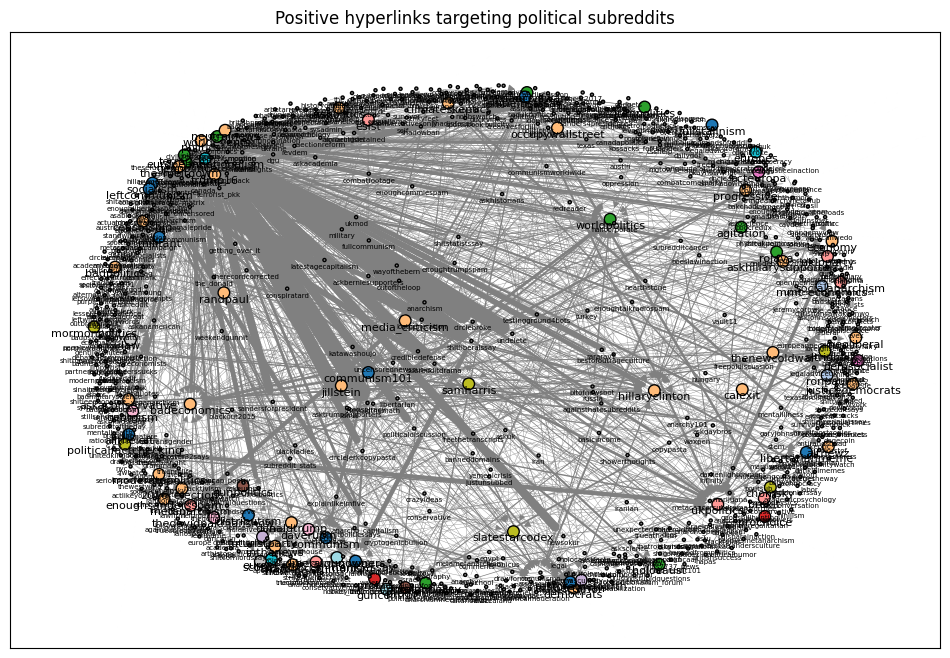

In [211]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_pt.nodes()]

node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

pos = nx.spring_layout(G_pt, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_pt, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")
# Define the positions and labels
labels = {node: node for node in G_pt.nodes()}

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    # Set font size based on node size
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")
##

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_pt.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_pt, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Positive hyperlinks targeting political subreddits")
plt.show()

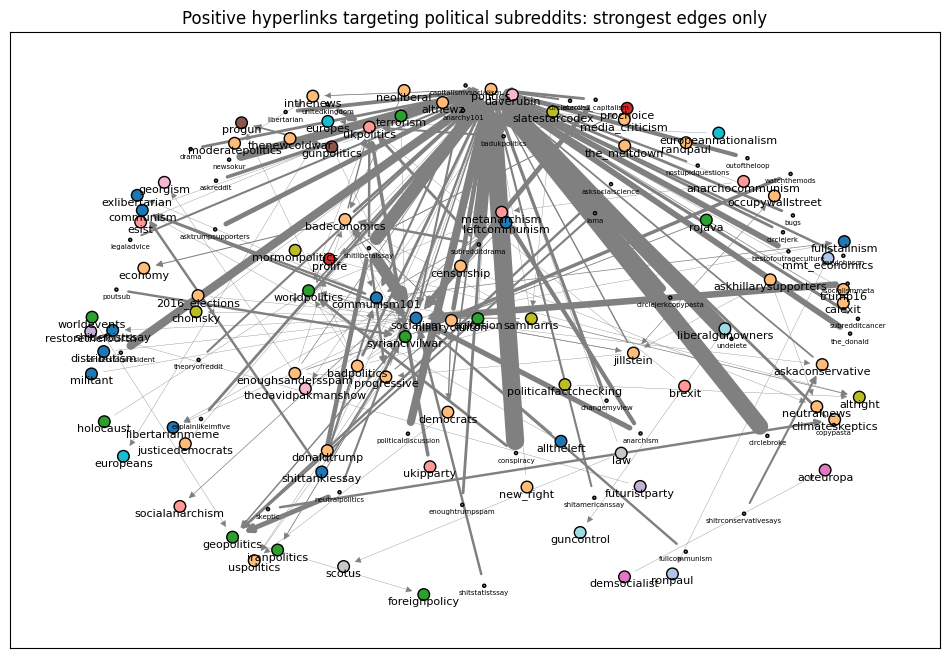

In [214]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Define colors
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i)

# Filter out grey nodes (i.e., only keep nodes in the communities)
non_grey_nodes = [node for node in G_pt.nodes() if node in node_colors]

# Filter edges: keep only edges with 'count' greater than a threshold (e.g., 5)
threshold = 5  # You can adjust this value to keep stronger edges
strong_edges = [(u, v, d) for u, v, d in G_pt.edges(data=True) if d['count'] > threshold]

# Create a new graph with only the non-grey nodes and strong edges
G_filtered = G_pt.subgraph(non_grey_nodes).copy()
G_filtered.add_edges_from(strong_edges)

# Recompute positions for the filtered graph
pos = nx.spring_layout(G_filtered, seed=42, k=0.8, scale=2)

# Assign node colors and sizes for the filtered graph
node_color_list = [node_colors.get(node, 'grey') for node in G_filtered.nodes()]
node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

# Define the positions and labels
labels = {node: node for node in G_filtered.nodes()}

# Draw nodes with community colors
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")

# Edge widths related to count attribute (in the filtered graph)
edge_widths = [d['count'] / 4 for (_, _, d) in G_filtered.edges(data=True)]

# Draw edges with widths based on count
nx.draw_networkx_edges(G_filtered, pos, edge_color="gray", arrows=True, width=edge_widths)

# Set title and show plot
plt.title("Positive hyperlinks targeting political subreddits: strongest edges only")
plt.show()
